# Inference in Hidden Markov Models continued: Viterbi Algorithm

This is a short post that continues from [the more-detailed alpha recursion HMM post](2018-05-02-hmm-alpha-recursion.ipynb). In this post I'll implement the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) like Barber does in ["Bayesian Reasoning and Machine Learning"](http://www.cs.ucl.ac.uk/staff/d.barber/brml/). Like before, I'm porting the MatLab code from the textbook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import nb_code.hmm_alpha_recursion as prev_post

In [2]:
# helper functions you can skip over :D
SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

def hide_ticks(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

## Viterbi algorithm in HMMs using message passing

The Viterbi algorithm finds the most-likely path $h_{1:T}$ for the visibles $v_{1:T}$, where $T$ is the timestep of the last observed visible.
The algorithm takes in the visibles $v_{1:T}$, the initial state $p(h_1)$, the transition probabilities $p(h_{t} \mid h_{t - 1})$, and the emission probabilities $p(v_t \mid h_t)$, and returns the list of most-likely hidden states $h_{1:T}$. 

I generated the required probabilities in the [alpha recursion HMM post](2018-05-02-hmm-alpha-recursion.ipynb).

### Algorithm

Barber frames the Viterbi algorithm as message passing using the max-product algorithm.

This version of the algorithm begins at the end of the hidden states ($h_T$), and computes an incoming message from future states. The message is meant to represent the effect of maximizing over those states.
Barber gives the messages as:

$$\mu(h_T) = 1$$

$$\mu(h_{t - 1}) = \max_{h_t} p(v_t \mid h_t)p(h_t \mid h_{t - 1})\mu(h_t).$$

Once the messages are computed, the algorithm then computes the most-likely state for $h_1$, and uses that to compute the most-likely state for $h_2$ and so on. It basically maximizes the marginal of $p(h_t \mid v_{1:T})$ and then uses the most-likely state for $h_t$ in the transition matrix for computing $p(h_{t + 1} \mid v_{1:T})$ so it returns a valid path.

$$h_1^* = \max_{h_1} p(v_1 \mid h_1)p(h_1)\mu(h_1)$$

$$h_t^* = \max_{h_t} p(v_t \mid h_t)p(h_t \mid h_{t - 1}^*)\mu(h_t).$$

Now in Python!

In [3]:
def viterbi(visibles, p_hidden_start, p_transition, p_emission):
    num_timestamps = visibles.shape[0]
    num_hidden_states = p_transition.shape[0]
    
    # messages[t] corresponds to mu(h_t), which is the message coming into h_t
    messages = np.zeros((num_timestamps, num_hidden_states))
    
    most_likely_states = np.zeros((num_timestamps,), dtype=int)

    # The message coming into the last node is 1 for all states
    messages[-1] = np.ones(num_hidden_states)

    # normalize!
    messages[-1] /= np.sum(messages[-1])
    
    # Compute the messages!
    for t in range(num_timestamps - 1, 0, -1):
        # use the data at time t to make mu[h_{t - 1}]
        
        # compute max p(v|h)p(h|h)mu(h)!
        
        # compute p(v|h)mu(h)
        message_and_emission = messages[t] * p_emission[visibles[t]]
        
        # compute p(v|h)p(h|h)mu(h)
        # message_and_emission.reshape(-1, 1): new_state x 1
        # np.tile(...): new_state x old_state
        # p_transition: new_state x old_state
        # np.tile(...) * p_transition: new_state x old_state
        all_h_ts = np.tile(
            message_and_emission.reshape(-1, 1),
            (1, num_hidden_states)
        ) * p_transition
        
        # the message is the value from the highest h_t
        messages[t - 1] = np.max(all_h_ts, axis=0)
        
        # and normalize
        messages[t - 1] /= np.sum(messages[t - 1])
    
    # now from the beginning! compute h_t* using these messages
    
    # argmax will give us the state.
    # argmax p(v_1|h_1)p(h_1)mu(h_1)
    most_likely_states[0] = np.argmax(
        p_hidden_start 
        * p_emission[visibles[0]] 
        * messages[0]
    )
    
    for t in range(1, num_timestamps):
        # argmax_h_t p(v_t|h_t)p(h_t|h_{t - 1})mu(h_t)
        most_likely_states[t] = np.argmax(
            p_emission[visibles[t], :]
            * p_transition[:, most_likely_states[t - 1]] 
            * messages[t]
        )
    
    return most_likely_states

most_likely_states = viterbi(
    prev_post.visibles, 
    prev_post.p_hidden_start,
    prev_post.p_transition,
    prev_post.p_emission,
)

print(most_likely_states)

[15  9  3  2  1  2  3  4 10  9]


## Visualizing

I can plot the most-likely states.

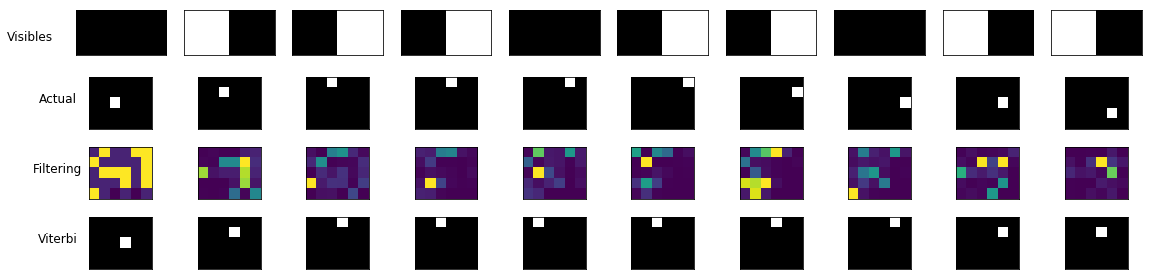

In [4]:
fig, all_axs = plt.subplots(4, prev_post.timesteps, figsize=(16, 4))
all_axs = all_axs.T

VISIBLES = 0
TRUE_STATES = 1
FILTERING = 2
VITERBI = 3

all_axs[0][VISIBLES].set_title('Visibles', x=-0.5, y=0.2)
all_axs[0][TRUE_STATES].set_title('Actual', x=-0.5, y=0.4)
all_axs[0][FILTERING].set_title('Filtering', x=-0.5, y=0.4)
all_axs[0][VITERBI].set_title('Viterbi', x=-0.5, y=0.4)

for i, (axs, hidden, visible, alpha, viterbi) in enumerate(zip(
    all_axs, 
    prev_post.hiddens, 
    prev_post.visibles, 
    prev_post.alphas,
    most_likely_states,
)):
    axs[VISIBLES].imshow([prev_post.map_visible_state_to_bump_creak[visible]], cmap='gray', vmin=0)
    hide_ticks(axs[VISIBLES])    
    
    axs[TRUE_STATES].imshow(prev_post.plot_state_in_room(hidden), cmap='gray')
    hide_ticks(axs[TRUE_STATES])
    
    axs[FILTERING].imshow(alpha.reshape(prev_post.height, prev_post.width))
    hide_ticks(axs[FILTERING])      

    axs[VITERBI].imshow(prev_post.plot_state_in_room(viterbi), cmap='gray')
    hide_ticks(axs[VITERBI])   
    
maybe_save_plot('2018-05-13-viterbi')
plt.show()

## See Also

 - [This post](2018-05-13-viterbi-message-passing.ipynb) builds on this post to show the Viterbi algorithm.
 - [The more-detailed alpha recursion HMM post](2018-05-02-hmm-alpha-recursion.ipynb).
 - [This notebook](https://github.com/jessstringham/blog/blob/master/notebooks/2018-05-13-hmm-check-results.ipynb) runs this code using the same example from Barber.